## Argo Test

In this notebook I'm attempting to replicate some of the glider results with Argo data in the region of 30E-40E and 50S-55S.

In [702]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from argopy import DataFetcher as ArgoDataFetcher
argo_loader = ArgoDataFetcher(parallel=True)
import scipy.ndimage as filter
filter.gaussian_filter1d

<function scipy.ndimage._filters.gaussian_filter1d(input, sigma, axis=-1, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)>

## Load Points, Make Profiles, Remove Profiles with Sampling Frequency Less Than 2m

In [703]:
#ds = argo_loader.region([30,40,-55,-50,0,2000]).to_xarray()
#ds=ds.argo.point2profile()

In [705]:
#ds.to_netcdf("argo_box_lon_{}-{}_lat_{}-{}.nc".format(30,40,-55,-50))

In [706]:
ds=xr.open_dataset("downloaded_data/argo_box_lon_30-40_lat_-55--50.nc")

In [799]:
ds

<xarray.Dataset>
Dimensions:                (N_PROF: 2099, N_LEVELS: 1006)
Coordinates:
  * N_PROF                 (N_PROF) int64 0 20 1 21 2 ... 761 726 1855 1853 1840
  * N_LEVELS               (N_LEVELS) int64 0 1 2 3 4 ... 1002 1003 1004 1005
    LATITUDE               (N_PROF) float64 -50.15 -51.69 ... -54.12 -51.07
    LONGITUDE              (N_PROF) float64 33.29 30.61 35.15 ... 33.44 31.39
    TIME                   (N_PROF) datetime64[ns] 2002-02-27T04:02:50 ... 20...
Data variables: (12/13)
    CONFIG_MISSION_NUMBER  (N_PROF) int32 1 1 1 1 1 1 1 1 1 ... 2 3 22 4 4 3 9 2
    CYCLE_NUMBER           (N_PROF) int32 12 12 13 13 14 14 ... 60 60 51 58 51
    DATA_MODE              (N_PROF) object 'D' 'D' 'D' 'D' ... 'R' 'A' 'A' 'A'
    DIRECTION              (N_PROF) object 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER        (N_PROF) int32 1900101 1900103 ... 6904068 6904066
    POSITION_QC            (N_PROF) int32 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    ...                     ...
    PRES_QC                (N_PROF, N_LEVELS) int32 ...
    PSAL                   (N_PROF, N_LEVELS) float32 ...
    PSAL_QC                (N_PROF) int32 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    TEMP                   (N_PROF, N_LEVELS) float32 ...
    TEMP_QC                (N_PROF) int32 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    TIME_QC                (N_PROF) int32 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://erddap.ifremer.fr/erddap
    Fetched_by:           amf2288
    Fetched_date:         2022/07/15
    Fetched_constraints:  [x=30.00/40.00; y=-55.00/-50.00; z=0.0/2000.0]
    Fetched_uri:          https://erddap.ifremer.fr/erddap/tabledap/ArgoFloat...
    history:              Variables filtered according to DATA_MODE; Variable...

In [743]:
depth_min=200
depth_max=2000
sample_max=3

median_dp=ds.PRES.where(ds.PRES<depth_max).where(ds.PRES>depth_min).diff('N_LEVELS').median('N_LEVELS')
ind_rate=median_dp.where(median_dp<sample_max,drop=True).N_PROF
ds_sel=ds.sel(N_PROF=ind_rate)
ds_interp=ds_sel.argo.interp_std_levels(np.arange(depth_min,1750,2))
ds_interp=ds_interp.sortby(ds_interp.N_PROF)

In [760]:
def get_ds_interp(ds,depth_min,depth_max,sample_max):
    median_dp=ds.PRES.where(ds.PRES<depth_max).where(ds.PRES>depth_min).diff('N_LEVELS').median('N_LEVELS')
    ind_rate=median_dp.where(median_dp<sample_max,drop=True).N_PROF
    ds_sel=ds.sel(N_PROF=ind_rate)
    ds_interp=ds_sel.argo.interp_std_levels(np.arange(depth_min,depth_max,2))
    ds_interp=ds_interp.sortby(ds_interp.N_PROF)
    return ds_interp.TEMP

In [761]:
CT_interp=get_ds_interp(ds,200,1800,3)

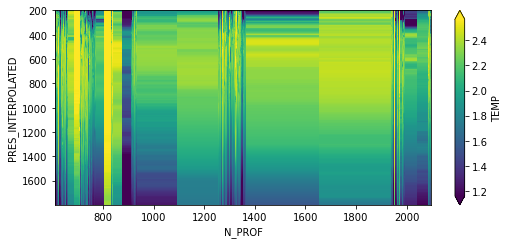

In [763]:
CT_interp.plot(y='PRES_INTERPOLATED',robust=True)
plt.gca().invert_yaxis()

## Filtering Analysis

In [764]:
def get_ds_filt(ds_interp,first,last,num):
    sigmas=np.logspace(first,last,num)
    temp=np.zeros((ds_interp.N_PROF.shape[0],ds_interp.PRES_INTERPOLATED.shape[0],num))

    for n in range(0,num):
        temp[:,:,n]=filter.gaussian_filter1d(ds_interp,sigma=sigmas[n],mode='nearest')

    ds_filt=xr.DataArray(temp,dims=['N_PROF','PRES_INTERPOLATED','FILT_SCALE'],
             coords={'N_PROF':ds_interp.N_PROF,'PRES_INTERPOLATED':ds_interp.PRES_INTERPOLATED,'FILT_SCALE':sigmas})
    return ds_filt

In [765]:
CT_filt=get_ds_filt(CT_interp,0.5,2.5,50)

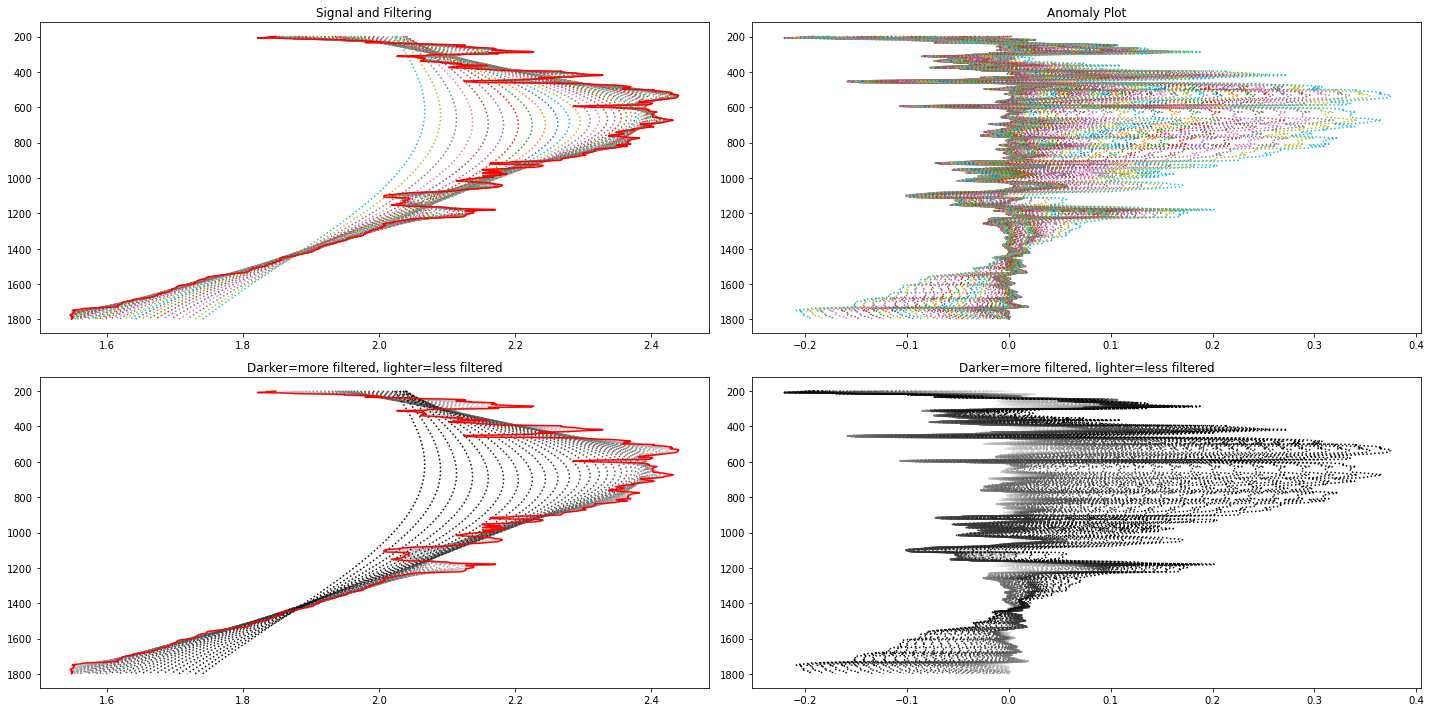

In [767]:
plt.figure(figsize=(20,10))
color=np.arange(0.01,1.01,1/len(CT_filt.FILT_SCALE))
color=np.flip(color,0)
prof_num=CT_filt.N_PROF[50]
prof=CT_interp.sel(N_PROF=prof_num)

plt.subplot(2,2,1)
plt.plot(prof,prof.PRES_INTERPOLATED,color='red',zorder=100)
plt.gca().invert_yaxis()
plt.title("Signal and Filtering")

plt.subplot(2,2,2)
plt.gca().invert_yaxis()
plt.title("Anomaly Plot")

plt.subplot(2,2,3)
plt.plot(prof,prof.PRES_INTERPOLATED,color='red',zorder=100)
plt.gca().invert_yaxis()
plt.title("Darker=more filtered, lighter=less filtered")

plt.subplot(2,2,4)
plt.gca().invert_yaxis()
plt.title("Darker=more filtered, lighter=less filtered")

#n regulates color only\
#sigma regulates FILT_SCALE

for n,sig in enumerate(CT_filt.FILT_SCALE):
    filt=CT_filt.sel(N_PROF=prof_num,FILT_SCALE=sig)
    anom=prof-filt
    
    plt.subplot(2,2,1)
    plt.plot(filt,filt.PRES_INTERPOLATED,linestyle=':')
    
    plt.subplot(2,2,2)
    plt.plot(anom,anom.PRES_INTERPOLATED,linestyle=':')
    
    plt.subplot(2,2,3)
    plt.plot(filt,filt.PRES_INTERPOLATED,linestyle=':',color=str(color[n]))
    
    plt.subplot(2,2,4)
    plt.plot(anom,anom.PRES_INTERPOLATED,linestyle=':',color=str(color[n]))

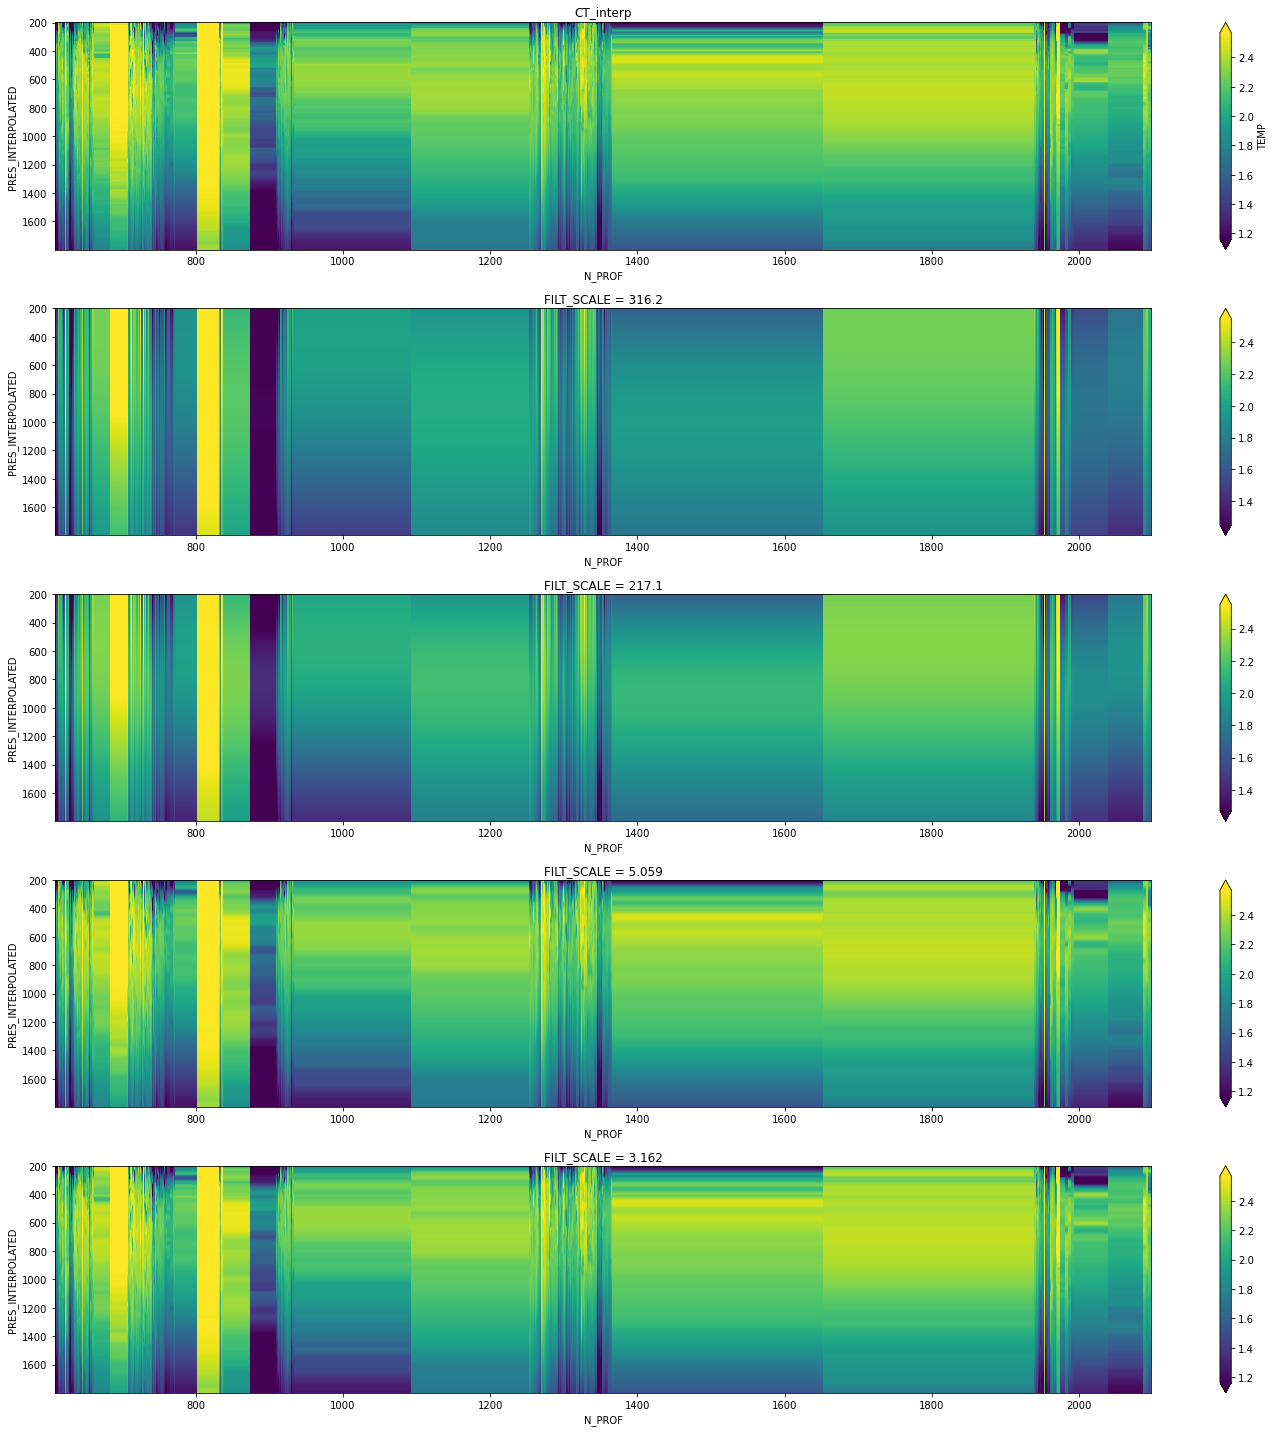

In [768]:
plt.figure(figsize=(20,20))
plt.subplot(5,1,1)
CT_interp.plot(y='PRES_INTERPOLATED',robust=True)
plt.title("CT_interp")
plt.gca().invert_yaxis()

scales=(CT_filt.FILT_SCALE[-1],CT_filt.FILT_SCALE[-5],CT_filt.FILT_SCALE[5],CT_filt.FILT_SCALE[0])
for n,sig in enumerate(scales):
    filt=CT_filt.sel(FILT_SCALE=sig)
    plt.subplot(5,1,n+2)
    filt.plot(y='PRES_INTERPOLATED',robust=True)
    plt.gca().invert_yaxis()
    
plt.subplots_adjust(hspace=0.4)

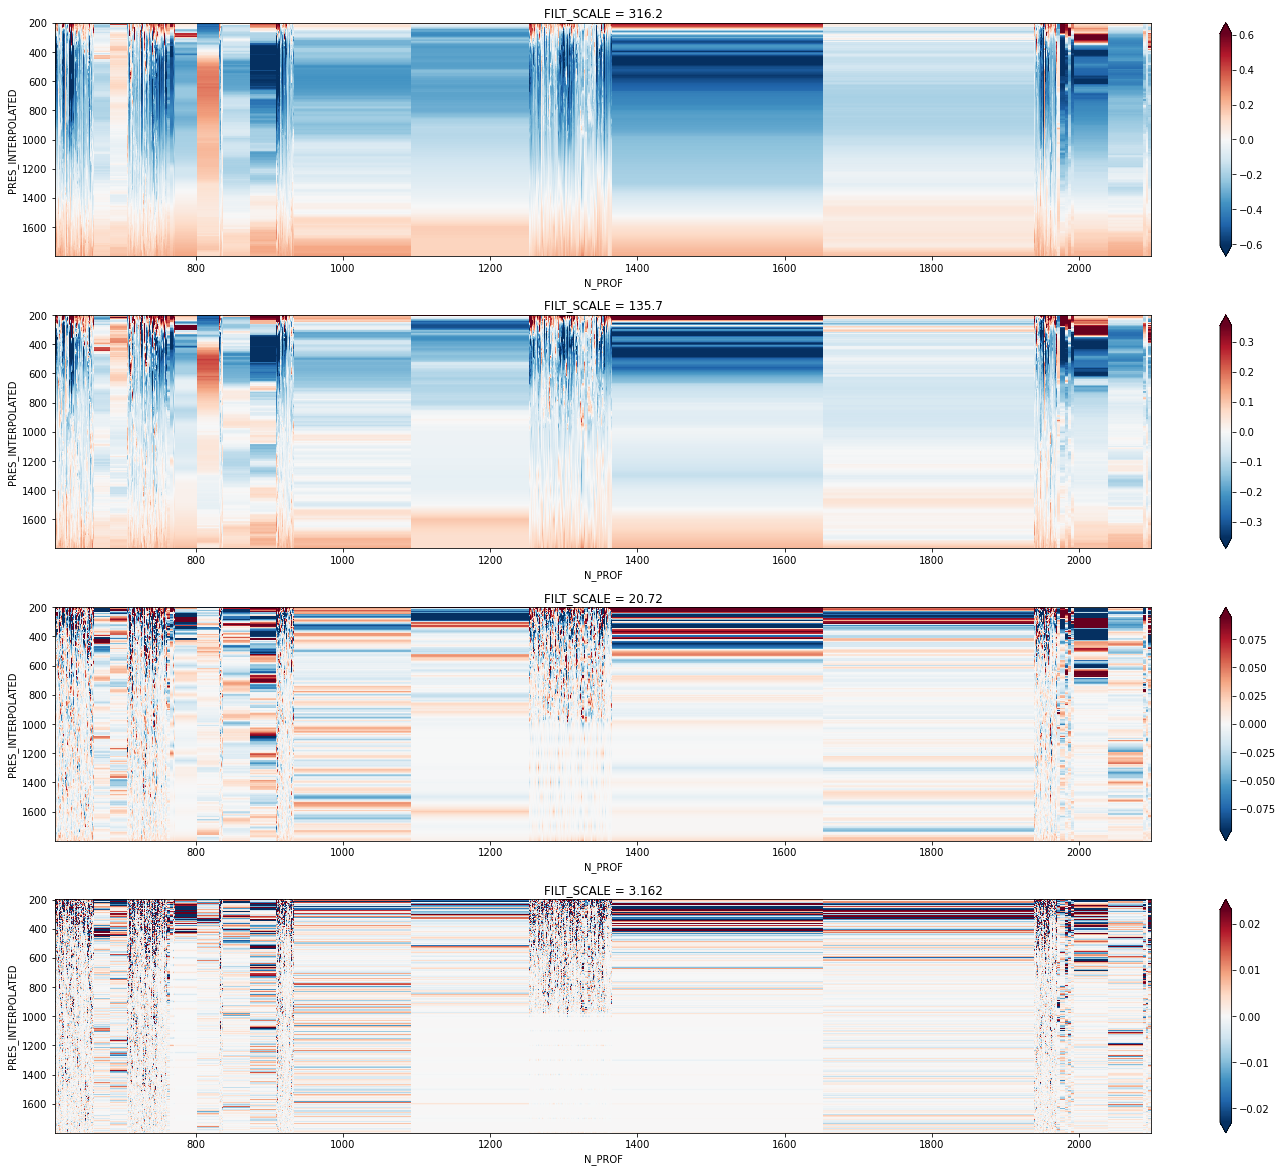

In [801]:
plt.figure(figsize=(20,20))

scales=(CT_filt.FILT_SCALE[-1],CT_filt.FILT_SCALE[-10],CT_filt.FILT_SCALE[20],CT_filt.FILT_SCALE[0])
for n,sig in enumerate(scales):
    filt=CT_filt.sel(FILT_SCALE=sig)
    anom=filt-CT_interp
    plt.subplot(5,1,n+1)
    anom.plot(y='PRES_INTERPOLATED',robust=True)
    plt.gca().invert_yaxis()
    
plt.subplots_adjust(hspace=0.4)

In [796]:
def get_var(ds_interp,ds_filt):
    var=np.zeros(len(ds_filt.FILT_SCALE))
    for n,sig in enumerate(ds_filt.FILT_SCALE):
        prof=ds_filt.sel(FILT_SCALE=sig)
        var[n]=(prof-ds_interp).var()
    return var

In [797]:
var_scale=get_var(CT_interp,CT_filt)

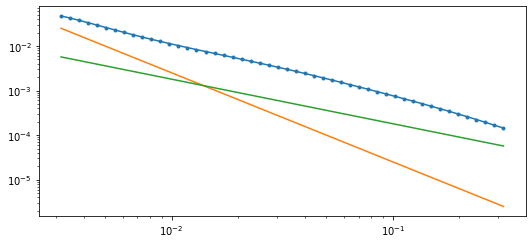

In [798]:
plt.plot(1/CT_filt.FILT_SCALE,var_scale,'.-')
plt.xscale('log')
plt.yscale('log')

x=1/CT_filt.FILT_SCALE
y_2=2.5*10**-7*x**-2
y_1=1.8*10**-5*x**-1

plt.plot(x,y_2)
plt.plot(x,y_1)

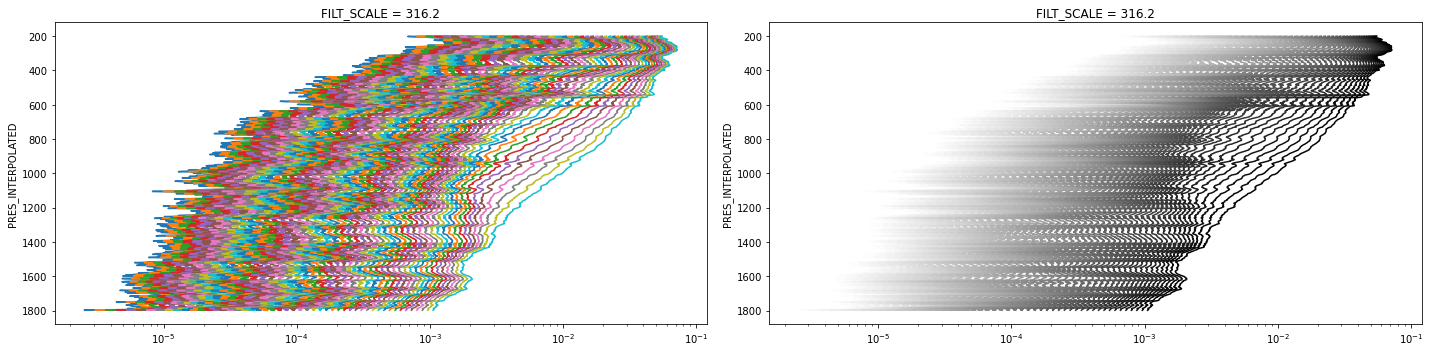

In [772]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.gca().invert_yaxis()
plt.xscale('log')

plt.subplot(1,2,2)
plt.gca().invert_yaxis()
plt.xscale('log')

for n,sig in enumerate(CT_filt.FILT_SCALE):
    prof=CT_filt.sel(FILT_SCALE=sig)
    
    plt.subplot(1,2,1)
    (prof-CT_interp).var(['N_PROF']).plot(y='PRES_INTERPOLATED',label=sig)
    
    plt.subplot(1,2,2)
    (prof-CT_interp).var(['N_PROF']).plot(y='PRES_INTERPOLATED',label=sig,color=str(color[n]))

In [773]:
interp_1000_3=get_ds_interp(ds,0,1000,3)
interp_2000_3=get_ds_interp(ds,1000,2000,3)
interp_1000_12=get_ds_interp(ds,0,1000,12)
interp_2000_12=get_ds_interp(ds,1000,2000,12)

In [774]:
filt_1000_3=get_ds_filt(interp_1000_3,0.5,2.5,50)
filt_2000_3=get_ds_filt(interp_2000_3,0.5,2.5,50)
filt_1000_12=get_ds_filt(interp_1000_12,0.5,2.5,50)
filt_2000_12=get_ds_filt(interp_2000_12,0.5,2.5,50)

In [775]:
var_1000_3=np.zeros(len(filt_1000_3.FILT_SCALE))
var_2000_3=np.zeros(len(filt_1000_3.FILT_SCALE))
var_1000_12=np.zeros(len(filt_1000_3.FILT_SCALE))
var_2000_12=np.zeros(len(filt_1000_3.FILT_SCALE))

for n,sig in enumerate(filt_1000_3.FILT_SCALE):
    prof_1000_3=filt_1000_3.sel(FILT_SCALE=sig,method='nearest')
    var_1000_3[n]=(prof_1000_3-interp_1000_3).var()
    
    prof_2000_3=filt_2000_3.sel(FILT_SCALE=sig,method='nearest')
    var_2000_3[n]=(prof_2000_3-interp_2000_3).var()
    
    prof_1000_12=filt_1000_12.sel(FILT_SCALE=sig,method='nearest')
    var_1000_12[n]=(prof_1000_12-interp_1000_12).var()
    
    prof_2000_12=filt_2000_12.sel(FILT_SCALE=sig,method='nearest')
    var_2000_12[n]=(prof_2000_12-interp_2000_12).var()

Text(0.5, 1.0, 'depth: [1000,2000]')

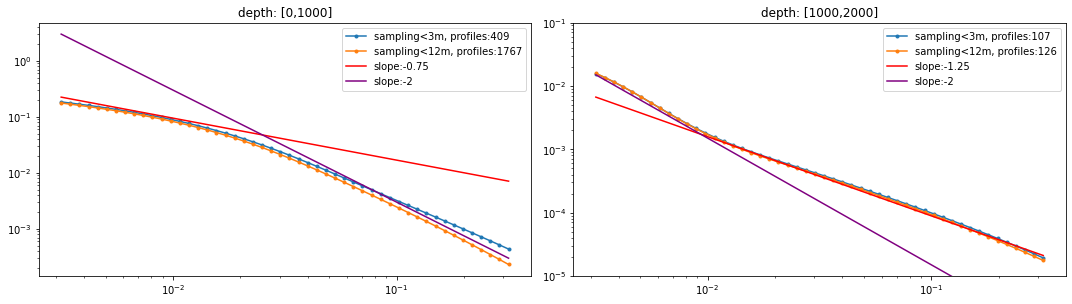

In [791]:
plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
plt.plot(1/filt_1000_3.FILT_SCALE,var_1000_3,'.-',label='sampling<3m, profiles:{}'.format(interp_1000_3.N_PROF.shape[0]))
plt.plot(1/filt_1000_12.FILT_SCALE,var_1000_12,'.-',label='sampling<12m, profiles:{}'.format(interp_1000_12.N_PROF.shape[0]))
plt.xscale('log')
plt.yscale('log')
x=1/filt_1000_3.FILT_SCALE
y_075=3*10**-3*x**-0.75
y_2=3*10**-5*x**-2
plt.plot(x,y_075,label='slope:-0.75',color='red')
plt.plot(x,y_2,label='slope:-2',color='purple')
plt.legend()
#plt.ylim(10**-5,10**-1)
plt.title("depth: [0,1000]")

plt.subplot(2,2,2)
plt.plot(1/filt_2000_3.FILT_SCALE,var_2000_3,'.-',label='sampling<3m, profiles:{}'.format(interp_2000_3.N_PROF.shape[0]))
plt.plot(1/filt_2000_12.FILT_SCALE,var_2000_12,'.-',label='sampling<12m, profiles:{}'.format(interp_2000_12.N_PROF.shape[0]))
plt.xscale('log')
plt.yscale('log')
x=1/filt_2000_3.FILT_SCALE
y_125=5*10**-6*x**-1.25
y_2=1.5*10**-7*x**-2
plt.plot(x,y_125,label='slope:-1.25',color='red')
plt.plot(x,y_2,label='slope:-2',color='purple')
plt.legend()
plt.ylim(10**-5,10**-1)
plt.title("depth: [1000,2000]")